<a href="https://colab.research.google.com/github/2303A52486/Employee-Salary-Prediction/blob/main/Employee_Salary_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [ ]:
# creating a dataframe

file_path = '/content/salary_prediction_data.csv'
df = pd.read_csv(file_path)

df

,Education,Experience,Location,Job_Title,Age,Gender,Salary
0,High School,8,Urban,Manager,63,Male,84620.053665
1,PhD,11,Suburban,Director,59,Male,142591.255894
2,Bachelor,28,Suburban,Manager,61,Female,97800.255404
3,High School,29,Rural,Director,45,Male,96834.671282
4,PhD,25,Urban,Analyst,26,Female,132157.786175
...,...,...,...,...,...,...,...
995,High School,8,Suburban,Analyst,25,Female,64683.389864
996,High School,24,Urban,Engineer,30,Female,74468.205020
997,Master,18,Rural,Analyst,44,Male,98207.026024
998,Bachelor,27,Suburban,Director,31,Female,108544.922720


In [ ]:
df.head()

,Education,Experience,Location,Job_Title,Age,Gender,Salary
0,High School,8,Urban,Manager,63,Male,84620.053665
1,PhD,11,Suburban,Director,59,Male,142591.255894
2,Bachelor,28,Suburban,Manager,61,Female,97800.255404
3,High School,29,Rural,Director,45,Male,96834.671282
4,PhD,25,Urban,Analyst,26,Female,132157.786175


In [ ]:
# Check for missing values
print("Missing Values:\n", df.isnull().sum())

Missing Values:
 Education     0
Experience    0
Location      0
Job_Title     0
Age           0
Gender        0
Salary        0
dtype: int64


In [ ]:
# to Encode categorical features
df_encoded = df.copy()
label_encoders = {}

for col in ['Education', 'Location', 'Job_Title', 'Gender']:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col])
    label_encoders[col] = le

# Display processed data
df_encoded.head()

,Education,Experience,Location,Job_Title,Age,Gender,Salary
0,1,8,2,3,63,1,84620.053665
1,3,11,1,1,59,1,142591.255894
2,0,28,1,3,61,0,97800.255404
3,1,29,0,1,45,1,96834.671282
4,3,25,2,0,26,0,132157.786175


## Future Salary Prediction Column

In [ ]:
# Reverse mapping for Job_Title
job_title_le = label_encoders['Job_Title']
job_titles = job_title_le.inverse_transform(df_encoded['Job_Title'])

# Define function
def compute_future_salary(current_salary, job_title, years=5):
    if job_title == 'Analyst':
        growth_rate = 0.10
    elif job_title == 'Manager':
        growth_rate = 0.07
    else:  # Director
        growth_rate = 0.05
    return current_salary * ((1 + growth_rate) ** years)

# Create column
df_encoded['Future_Salary'] = [
    compute_future_salary(row['Salary'], title)
    for row, title in zip(df_encoded.to_dict('records'), job_titles)
]

In [ ]:
# adding noise

np.random.seed(42)
df_encoded['Future_Salary_Noisy'] = df_encoded['Future_Salary'] + np.random.normal(0, 5000, size=len(df_encoded))

## Train-Test Split and Model Training

In [ ]:
# Features and target
X = df_encoded.drop(['Future_Salary', 'Future_Salary_Noisy'], axis=1)
y = df_encoded['Future_Salary_Noisy']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest Regressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predictions
preds = model.predict(X_test)

## Evaluating the Model

In [ ]:
# evalution metrics
mae = mean_absolute_error(y_test, preds)
mse = mean_squared_error(y_test, preds)
r2 = r2_score(y_test, preds)

print("Final Model Evaluation (With Noise):")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R² Score: {r2:.2f}")

Final Model Evaluation (With Noise):
Mean Absolute Error (MAE): 4615.45
Mean Squared Error (MSE): 35176673.44
R² Score: 0.98


## Testing on new data

In [ ]:
# creating new data
new_data = pd.DataFrame({
    'Education': ['PhD', 'High School'],
    'Experience': [10, 5],
    'Location': ['Urban', 'Rural'],
    'Job_Title': ['Manager', 'Analyst'],
    'Age': [45, 30],
    'Gender': ['Male', 'Female'],
    'Salary': [120000, 50000]
})

# Applying label encoders
for col in ['Education', 'Location', 'Job_Title', 'Gender']:
    new_data[col] = label_encoders[col].transform(new_data[col])

# Predict future salary for new employees
predicted_salaries = model.predict(new_data)

# Display predictions
for i in range(len(new_data)):
    print(f"Employee {i+1}: Predicted Future Salary after 5 years = ₹{predicted_salaries[i]:.2f}")

Employee 1: Predicted Future Salary after 5 years = ₹167435.34
Employee 2: Predicted Future Salary after 5 years = ₹79368.60


## Ploting Graphs

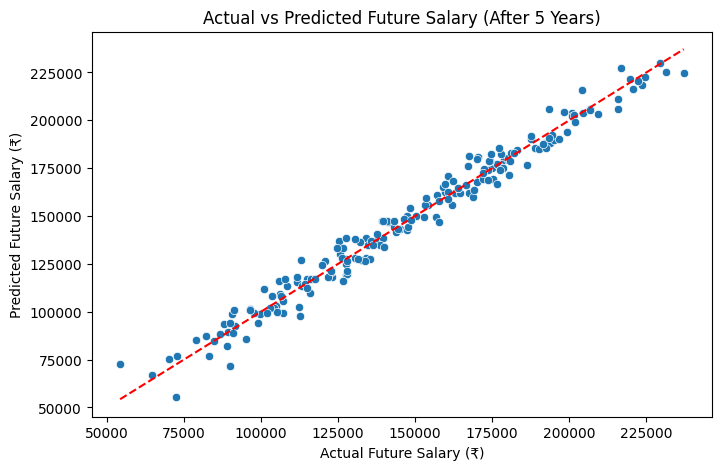

In [ ]:
# Scatter plot
plt.figure(figsize=(8,5))
sns.scatterplot(x=y_test, y=preds)
plt.xlabel("Actual Future Salary (₹)")
plt.ylabel("Predicted Future Salary (₹)")
plt.title("Actual vs Predicted Future Salary (After 5 Years)")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()

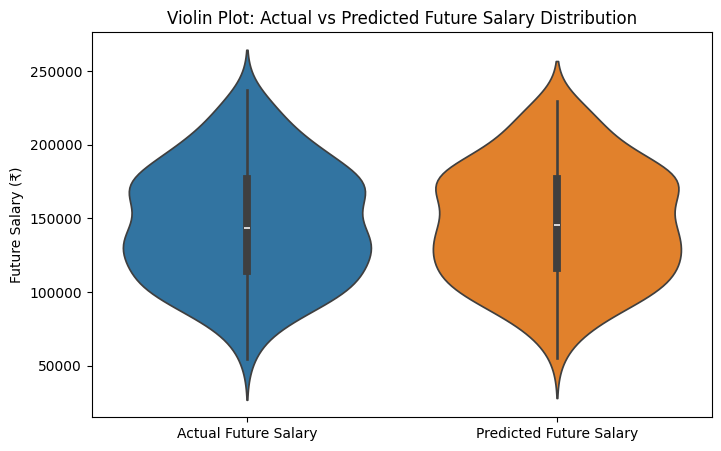

In [ ]:
# violin plot
violin_data = pd.DataFrame({
    'Actual Future Salary': y_test.values,
    'Predicted Future Salary': preds
})

plt.figure(figsize=(8,5))
sns.violinplot(data=violin_data)
plt.title("Violin Plot: Actual vs Predicted Future Salary Distribution")
plt.ylabel("Future Salary (₹)")
plt.show()

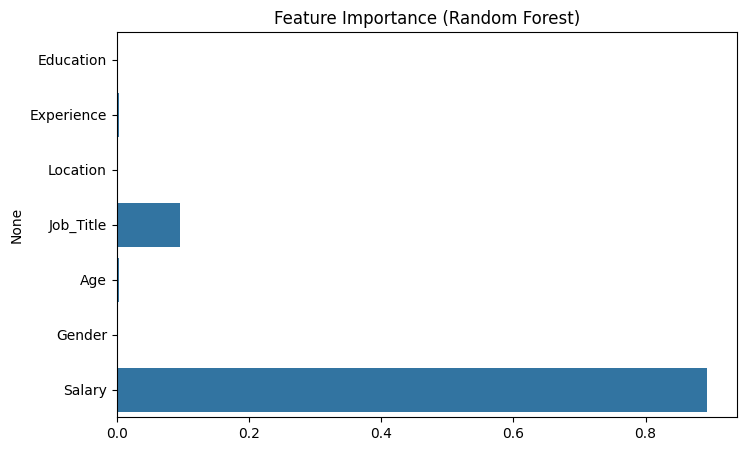

In [ ]:
# feature improtance
importances = model.feature_importances_
features = X.columns

plt.figure(figsize=(8,5))
sns.barplot(x=importances, y=features)
plt.title("Feature Importance (Random Forest)")
plt.show()

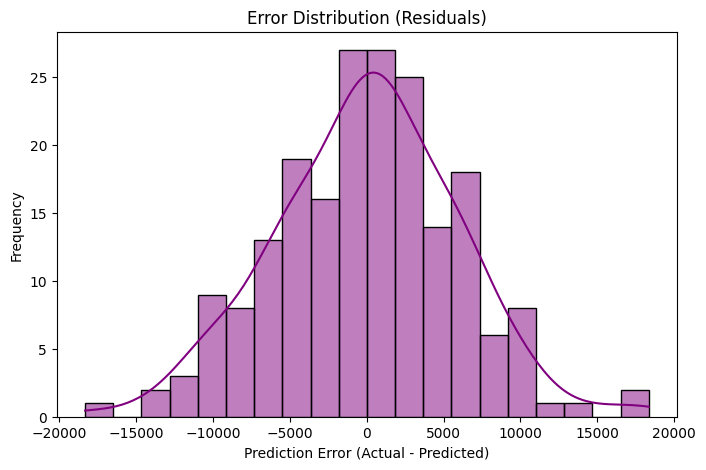

In [ ]:
# Error Distribution (Residual Plot)
errors = y_test - preds

plt.figure(figsize=(8,5))
sns.histplot(errors, bins=20, kde=True, color='purple')
plt.title("Error Distribution (Residuals)")
plt.xlabel("Prediction Error (Actual - Predicted)")
plt.ylabel("Frequency")
plt.show()

Salary Growth Visualization\
Compare current salary vs future salary (actual vs predicted).

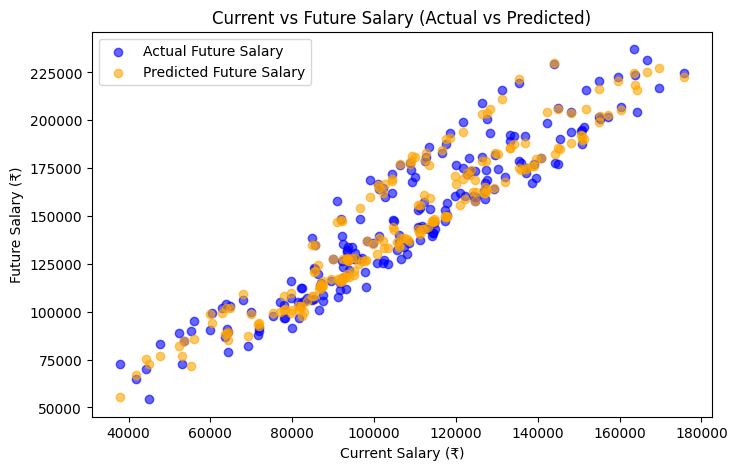

In [ ]:
plt.figure(figsize=(8,5))
plt.scatter(X_test['Salary'], y_test, label="Actual Future Salary", color='blue', alpha=0.6)
plt.scatter(X_test['Salary'], preds, label="Predicted Future Salary", color='orange', alpha=0.6)
plt.xlabel("Current Salary (₹)")
plt.ylabel("Future Salary (₹)")
plt.title("Current vs Future Salary (Actual vs Predicted)")
plt.legend()
plt.show()

Correlation Metrics (HeatMap)

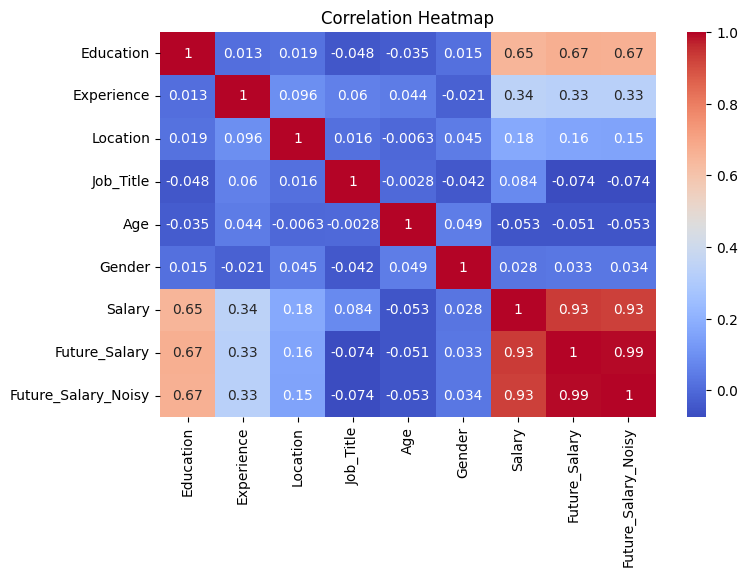

In [ ]:
plt.figure(figsize=(8,5))
sns.heatmap(df_encoded.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()